In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

In [2]:
file_path = "..\\data\\stroke_data.csv"
sk = pd.read_csv(file_path)

In [3]:
sk

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
sk.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# Stroke Prediction Project

This project aims to predict stroke risk using the `stroke-data.csv` dataset from Kaggle. Due to the rarity of stroke cases, we will address class imbalance and focus on metrics like **Recall** and **ROC-AUC** to ensure high-risk patients are identified. Key steps include:
- Data cleaning and feature selection
- Model training and evaluation
- Emphasis on clinical usefulness

The goal is to create a reliable tool for early stroke risk detection.

In [6]:
sk.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
sk.duplicated().sum()

np.int64(0)

In [8]:
null_data = sk[sk['bmi'].isnull()]

In [9]:
null_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [10]:
sk['bmi'] = sk['bmi'].fillna(sk.groupby('age')['bmi'].transform('median'))

In [11]:
sk.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [12]:
sk.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [13]:
sk.stroke.value_counts(normalize = True)

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

## Exploratory Data Analysis
The dataset contains **5110 records** and **12 columns**: `id`, `gender`, `age`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `avg_glucose_level`, `bmi`, `smoking_status`, `stroke`. Key observations:
- **Missing Values**: The `bmi` column has 201 missing entries (4909 non-null out of 5110). The `smoking_status` column includes an `Unknown` category that may need handling.
- **Class Imbalance**: Approximately 4.87% of records have `stroke=1` (249/5110), indicating a significant class imbalance that requires techniques like SMOTE for modeling.
  

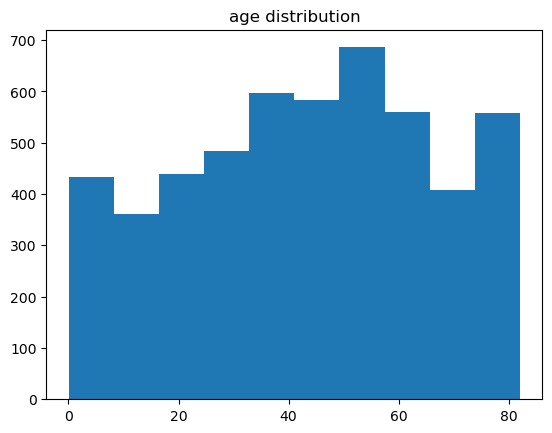

In [14]:
plt.title('age distribution')
plt.hist(sk.age)
plt.show()

stroke
0    4861
1     249
Name: count, dtype: int64


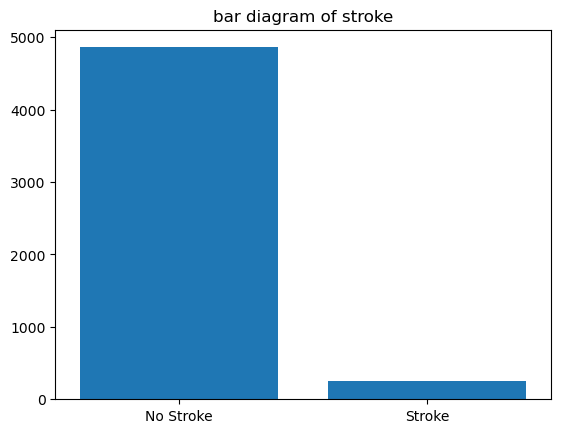

In [15]:
stroke_counts = sk.stroke.value_counts()
print(stroke_counts)

plt.title('bar diagram of stroke')
plt.bar(stroke_counts.index , stroke_counts.values)
plt.xlim(-0.5, 1.5)
plt.xticks(stroke_counts.index, ['No Stroke', 'Stroke'])  # Custom labels for 0 and 1
plt.show()

In [16]:
sk.age.value_counts()

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.08       2
0.40       2
Name: count, Length: 104, dtype: int64

In [17]:
sk.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [18]:
sk_1 = sk[sk.smoking_status != 'Unknown']
sk_1

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.45,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5102,45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.70,never smoked,0
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.70,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0


In [19]:
sk_1.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [20]:
sk_1_count = sk_1.stroke.value_counts()
sk_1_count

stroke
0    3364
1     202
Name: count, dtype: int64

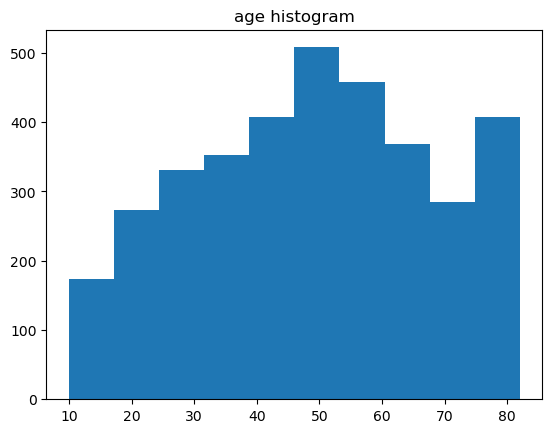

In [21]:
plt.title('age histogram')
plt.hist(sk_1.age)
plt.show()

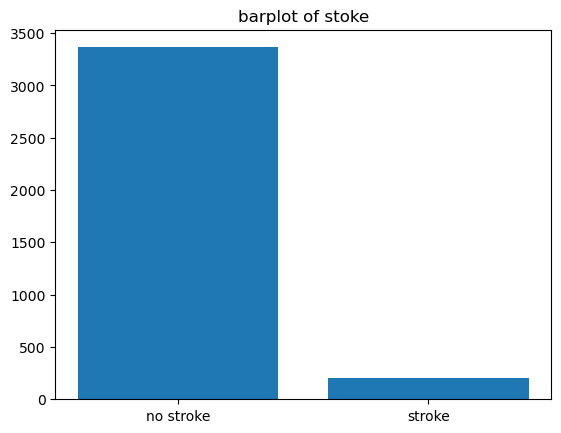

In [22]:
plt.title('barplot of stoke')
plt.bar(sk_1_count.index,sk_1_count.values)
plt.xticks(sk_1_count.index , ['no stroke' , 'stroke'])
plt.show()

In [23]:
sk_1 = sk_1.drop('id' ,axis = 1)
sk_1.shape

(3566, 11)

In [24]:
encoded_sk = pd.get_dummies(sk_1,columns = ['gender' , 'ever_married' , 'work_type' , 'Residence_type' , 'smoking_status'],dtype = bool)
encoded_sk

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60,1,False,True,False,False,...,False,False,True,False,False,False,True,True,False,False
1,61.0,0,0,202.21,29.45,1,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
2,80.0,0,1,105.92,32.50,1,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
3,49.0,0,0,171.23,34.40,1,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
4,79.0,1,0,174.12,24.00,1,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102,57.0,0,0,77.93,21.70,0,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
5105,80.0,1,0,83.75,28.70,0,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
5106,81.0,0,0,125.20,40.00,0,True,False,False,False,...,False,False,False,True,False,False,True,False,True,False
5107,35.0,0,0,82.99,30.60,0,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False


In [25]:
encoded_sk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3566 entries, 0 to 5108
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             3566 non-null   float64
 1   hypertension                    3566 non-null   int64  
 2   heart_disease                   3566 non-null   int64  
 3   avg_glucose_level               3566 non-null   float64
 4   bmi                             3566 non-null   float64
 5   stroke                          3566 non-null   int64  
 6   gender_Female                   3566 non-null   bool   
 7   gender_Male                     3566 non-null   bool   
 8   gender_Other                    3566 non-null   bool   
 9   ever_married_No                 3566 non-null   bool   
 10  ever_married_Yes                3566 non-null   bool   
 11  work_type_Govt_job              3566 non-null   bool   
 12  work_type_Never_worked          3566 no

In [26]:
encoded_sk = encoded_sk.drop(['gender_Female' , 'gender_Other', 'ever_married_No', 'Residence_type_Rural'], axis = 1)
encoded_sk
print(encoded_sk.shape)
print(encoded_sk.columns)

(3566, 17)
Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


age                               0.250794
hypertension                      0.134717
heart_disease                     0.129346
avg_glucose_level                 0.128714
ever_married_Yes                  0.078076
work_type_Self-employed           0.060628
smoking_status_formerly smoked    0.055798
smoking_status_never smoked       0.041747
work_type_children                0.034421
work_type_Private                 0.023860
work_type_Govt_job                0.018024
gender_Male                       0.015634
work_type_Never_worked            0.015384
bmi                               0.008584
smoking_status_smokes             0.007872
Residence_type_Urban              0.007872
Name: stroke, dtype: float64
figure saved


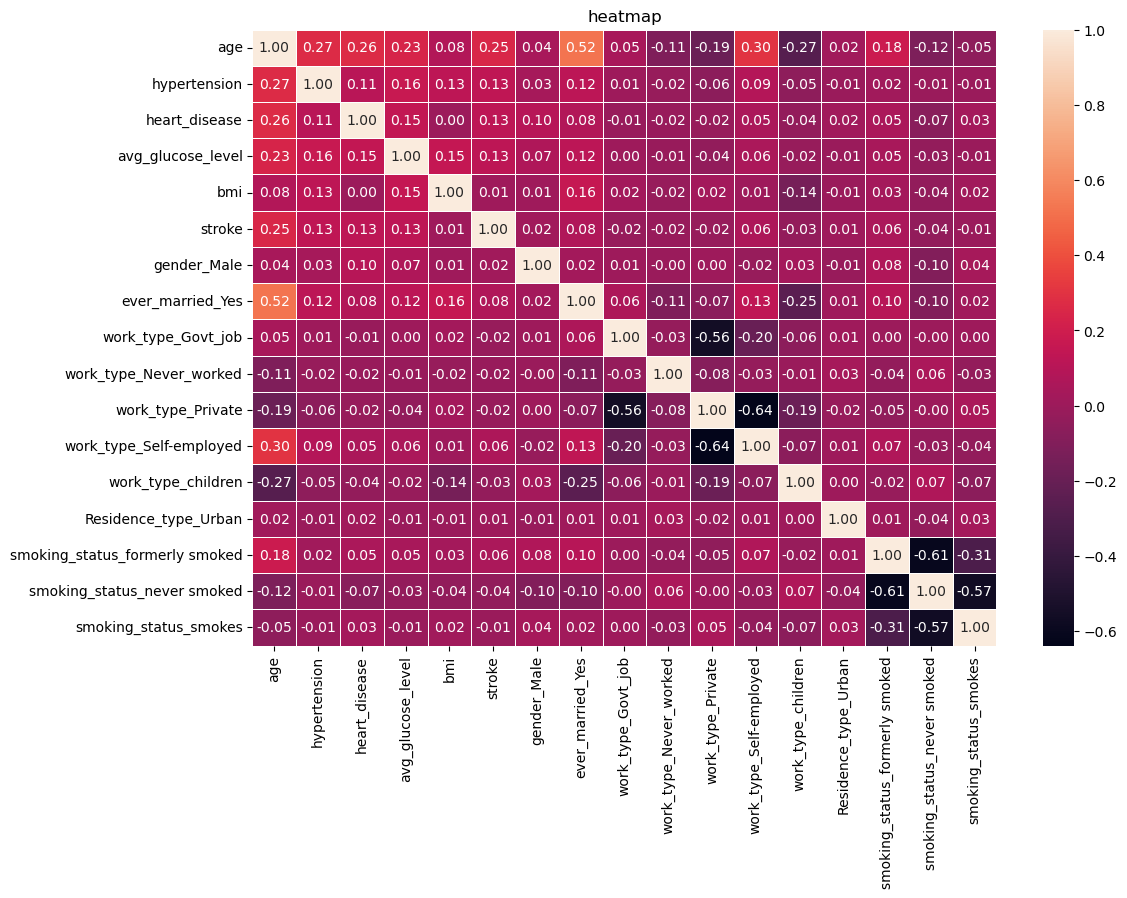

In [27]:
corr_matrix = encoded_sk.corr()
stroke_matrix = corr_matrix['stroke'].drop('stroke')
sorted_matrix = stroke_matrix.abs().sort_values(ascending = False)
print(sorted_matrix)

plt.figure(figsize = (12,8))
plt.title('heatmap')
sns.heatmap(encoded_sk.corr(),
            annot = True,
            fmt = '.2f',
            linewidths = 0.5
           )
plt.savefig("..\\visualization\\heatmap.png", dpi = 300 , bbox_inches = 'tight')
print('figure saved')
plt.show()

In [28]:
print('top 3 predictors are: \n' , sorted_matrix.head(3))

top 3 predictors are: 
 age              0.250794
hypertension     0.134717
heart_disease    0.129346
Name: stroke, dtype: float64


In [29]:
encoded_sk.to_csv('..\\data\\processed_stroke_data.csv', index = False)

In [30]:
processed_df = pd.read_csv('..\\data\\processed_stroke_data.csv')

print(processed_df.shape)
print(processed_df.columns)

(3566, 17)
Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


In [55]:
X = processed_df.drop('stroke', axis = 1)
y = processed_df['stroke']

x_train,x_test,y_train,y_test = train_test_split(X, y, random_state = 42, train_size = 0.8)
print('y_train shape',y_train.value_counts())
smote = SMOTE(random_state = 42)
x_train_sampled , y_train_sampled = smote.fit_resample(x_train,y_train)

print(' \nafter applying SMOTE \n')
print('y_train shape',y_train_sampled.value_counts())
print('y_train',y_train_sampled.shape)

y_train shape stroke
0    2699
1     153
Name: count, dtype: int64
 
after applying SMOTE 

y_train shape stroke
1    2699
0    2699
Name: count, dtype: int64
y_train (5398,)


In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['age', 'avg_glucose_level', 'bmi']

preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', MinMaxScaler(), columns_to_scale)
    ]
)

scaled_x_train = preprocessor.fit_transform(x_train_sampled)
scaled_column = pd.DataFrame(scaled_x_train , columns = columns_to_scale)
scaled_x_train_sampled_df = x_train_sampled.copy()
scaled_x_train_sampled_df[columns_to_scale] = scaled_column
print(scaled_x_train_sampled_df.shape)

print('\n')
scaled_y_test = preprocessor.transform(x_test)
scaled_column_ = pd.DataFrame(scaled_y_test,columns = columns_to_scale)
scaled_x_test = x_test.copy()
scaled_x_test[columns_to_scale] = scaled_column_
print(scaled_x_test.shape)

(5398, 16)


(714, 16)
